## Gender Classification using DL

#### Imports

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import shutil
from shutil import copyfile

import keras
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator # from keras.preprocessing.image import ImageDataGenerator is deprecated
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import load_img, img_to_array
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### Preparing the data

In [3]:
base_dir  = "../Dataset/faces/"

In [6]:
mytrain_test_list = []
mylabels_list = []
myitem_list = []
vis_images = []; vis_labels =[]

train_test_list = tf.io.gfile.listdir(base_dir)
for train_test in train_test_list:
    path1 = os.path.join(base_dir, train_test)
    label_list = tf.io.gfile.listdir(path1)
    for label in label_list:
        my_path = os.path.join(path1, label)
        item_files = os.listdir(my_path)

        mytrain_test_list.append(train_test)
        mylabels_list.append(label)
        myitem_list.append(len(item_files))
        
        my_files = item_files[0:5]
        for file in my_files:
            vis_images.append(os.path.join(my_path, file))
            vis_labels.append(label)
        
pd.DataFrame({'Train/Test':mytrain_test_list, 'Labels':mylabels_list, \
              'Number of Items':myitem_list})

,Train/Test,Labels,Number of Items
0,test,male,5808
1,test,female,5841
2,train,male,23766
3,train,female,23243


#### Data Augmentation

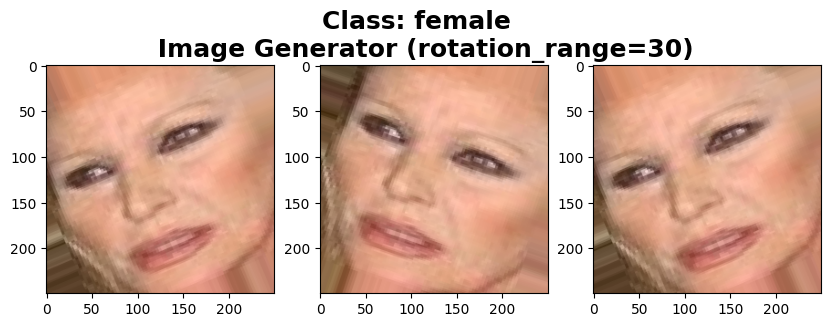

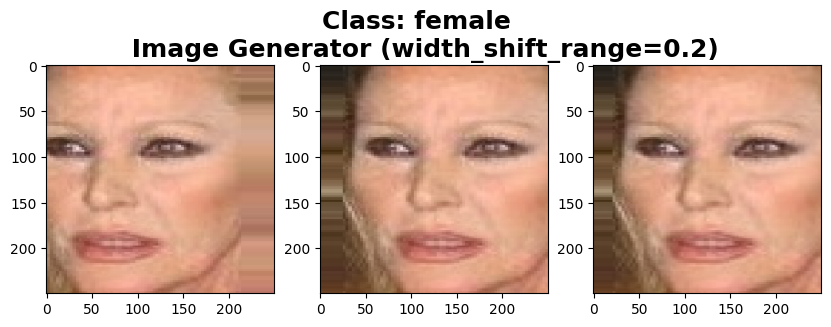

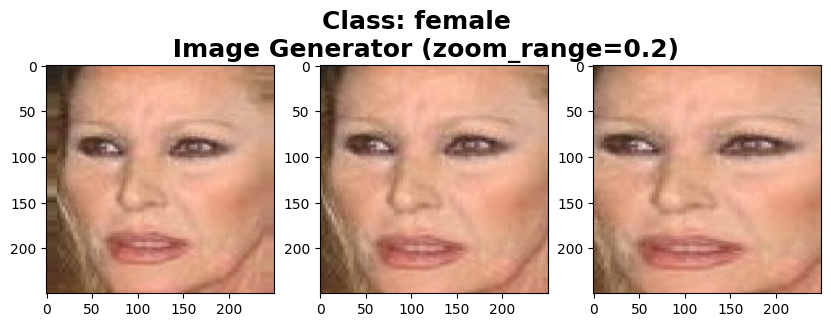

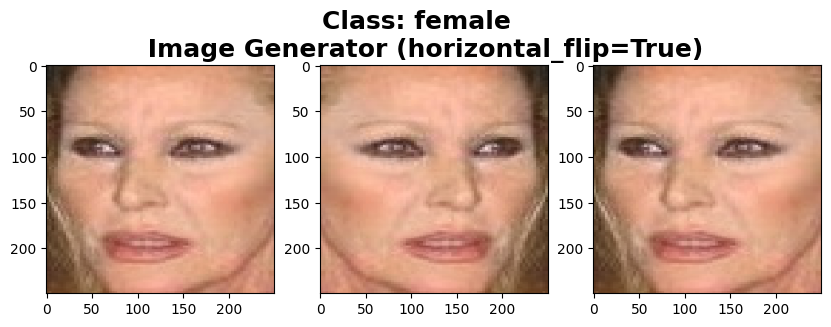

In [14]:
def show_ImageDataGenerator(vis_images, vis_labels, image_index):
    #Loads image in from the set image path
    class_label = vis_labels[image_index]
    img = tf.keras.preprocessing.image.load_img(vis_images[image_index], target_size= (250,250))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    #Creates our batch of one image
    def show_image(datagen, param):
        pic = datagen.flow(img_tensor, batch_size =1)
        plt.figure(figsize=(10,3.5))
        #Plots our figures
        for i in range(1,4):
            plt.subplot(1, 3, i)
            batch = pic.next()
            image_ = batch[0].astype('uint8')
            plt.imshow(image_)
        plt.suptitle(f"Class: {class_label} \n Image Generator ({param})",fontsize=18, fontweight='bold')

        plt.show()

    datagen = ImageDataGenerator(rotation_range=30)
    show_image(datagen, "rotation_range=30")

    datagen = ImageDataGenerator(width_shift_range=0.2)
    show_image(datagen, "width_shift_range=0.2")

    datagen = ImageDataGenerator(zoom_range=0.2)
    show_image(datagen, "zoom_range=0.2")

    datagen = ImageDataGenerator(horizontal_flip=True)
    show_image(datagen, "horizontal_flip=True")

show_ImageDataGenerator(vis_images, vis_labels, image_index = 9)

In [8]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

    # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
    train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    return train_generator, validation_generator

In [9]:
training_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')
print(validation_dir)

../Dataset/faces/test


In [10]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [32]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

#### VGG16 Setup

##### Model Definition:

In [23]:
# Load the pre-trained VGG19 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

In [24]:
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # 2 classes: male and female

In [25]:
# Create the final model
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

##### Some tuning for learning rate:

In [27]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [28]:
vgg16_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

##### Training:

In [30]:
# Train the model
history = vgg16_model.fit(train_generator,
                       epochs=5,
                       validation_data=validation_generator,
                       callbacks=lr_schedule,
                       verbose=1)

Epoch 1/5
1470/1470 [==============================] - 508s 345ms/step - loss: 0.2889 - accuracy: 0.8812 - val_loss: 0.1948 - val_accuracy: 0.9234 - lr: 1.0000e-04
Epoch 2/5
1470/1470 [==============================] - 513s 349ms/step - loss: 0.2762 - accuracy: 0.8874 - val_loss: 0.2109 - val_accuracy: 0.9171 - lr: 1.1220e-04
Epoch 3/5
1470/1470 [==============================] - 508s 346ms/step - loss: 0.2673 - accuracy: 0.8916 - val_loss: 0.2010 - val_accuracy: 0.9202 - lr: 1.2589e-04
Epoch 4/5
1470/1470 [==============================] - 511s 348ms/step - loss: 0.2603 - accuracy: 0.8931 - val_loss: 0.1990 - val_accuracy: 0.9201 - lr: 1.4125e-04
Epoch 5/5
1470/1470 [==============================] - 510s 347ms/step - loss: 0.2575 - accuracy: 0.8958 - val_loss: 0.2115 - val_accuracy: 0.9145 - lr: 1.5849e-04


##### Performance:

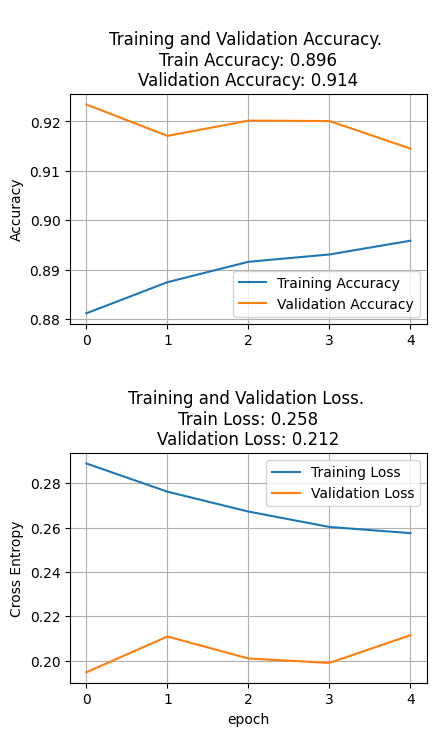

In [33]:
plot_history(history)

##### Prediction:

1/1 [==============================] - 0s 240ms/step


2023-07-06 20:16:52.935463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-06 20:16:52.941812: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


 Class Name: 'male' Confidence: 67.15


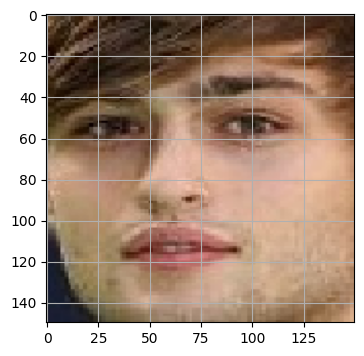

In [35]:
def make_your_prediction(YOUR_IMAGE_PATH = None):
    if YOUR_IMAGE_PATH == None:
        YOUR_IMAGE_PATH = "../Dataset/faces/test/male/063503.jpg.jpg" 
    
    img = image.load_img(YOUR_IMAGE_PATH, target_size=(150, 150))
    plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = vgg16_model.predict(images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])

    class_name = train_generator.class_indices
    class_name_inverted = {y: x for x, y in class_name.items()}

    if classes[0]>0.5:
        print(f" Class Name: '{class_name_inverted[1]}' Confidence: {100 * np.max(score):.2f}")
    else:
        print(f" Class Name: '{class_name_inverted[0]}' Confidence: {100 * np.max(score):.2f}")

make_your_prediction(YOUR_IMAGE_PATH = None)

1/1 [==============================] - 0s 22ms/step
 Class Name: 'female' Confidence: 50.01


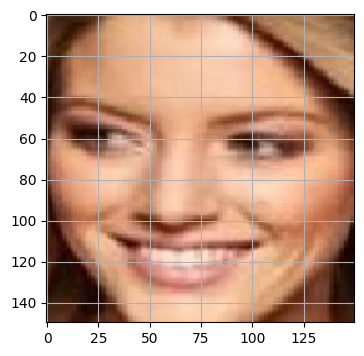

In [36]:
make_your_prediction("../Dataset/faces/test/female/112992.jpg.jpg")

__________

#### ResNet50 Setup

##### Model Definition:

In [37]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

In [39]:
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output 
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # 2 classes: male and female

In [40]:
# create the final model
resnet50_model = Model(inputs=base_model.input, outputs=predictions)
resnet50_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

##### Some Tuning for learning rate:

In [41]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [42]:
resnet50_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

##### Training:

In [43]:
# Train the model
resnet50_history = resnet50_model.fit(train_generator,
                       epochs=5,
                       validation_data=validation_generator,
                       callbacks=lr_schedule,
                       verbose=1)

Epoch 1/5


2023-07-06 20:18:35.861699: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-06 20:18:35.913922: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


1470/1470 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.5393

2023-07-06 20:23:08.698825: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-06 20:23:08.745994: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


1470/1470 [==============================] - 336s 227ms/step - loss: 0.7103 - accuracy: 0.5393 - val_loss: 0.6632 - val_accuracy: 0.5409 - lr: 1.0000e-04
Epoch 2/5
1470/1470 [==============================] - 383s 261ms/step - loss: 0.6860 - accuracy: 0.5476 - val_loss: 0.6859 - val_accuracy: 0.4990 - lr: 1.1220e-04
Epoch 3/5
1470/1470 [==============================] - 420s 286ms/step - loss: 0.6872 - accuracy: 0.5425 - val_loss: 0.6792 - val_accuracy: 0.5256 - lr: 1.2589e-04
Epoch 4/5
1470/1470 [==============================] - 412s 280ms/step - loss: 0.6815 - accuracy: 0.5506 - val_loss: 0.6799 - val_accuracy: 0.5519 - lr: 1.4125e-04
Epoch 5/5
1470/1470 [==============================] - 409s 278ms/step - loss: 0.6833 - accuracy: 0.5534 - val_loss: 0.6689 - val_accuracy: 0.6888 - lr: 1.5849e-04


##### Performance:

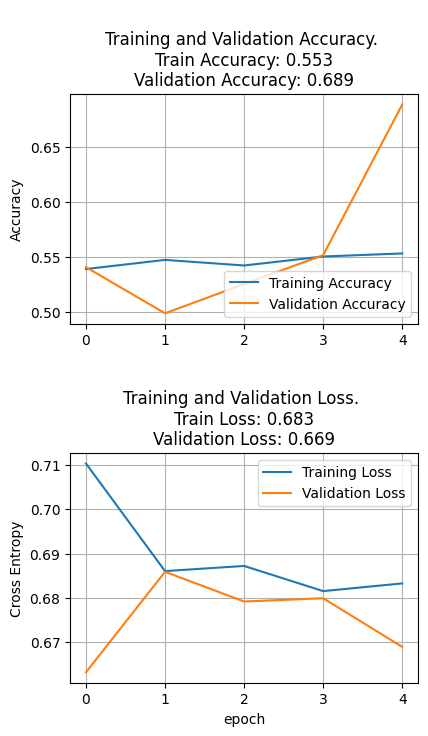

In [44]:
plot_history(resnet50_history)

__________

#### InceptionV3 Setup

##### Model Definition:

In [45]:
# load the pre-trained inception model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

In [46]:
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # 2 classes: adult and child

In [47]:
# Create the final model
inceptionv3_model = Model(inputs=base_model.input, outputs=predictions)

In [48]:
inceptionv3_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0]

##### Some tuning for learning rate:

In [49]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [50]:
inceptionv3_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

##### Training:

In [51]:
# Train the model
inceptionv3_history = inceptionv3_model.fit(train_generator,
                       epochs=5,
                       validation_data=validation_generator,
                       callbacks=lr_schedule,
                       verbose=1)

Epoch 1/5


2023-07-06 20:52:55.969654: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-06 20:52:56.032035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


1470/1470 [==============================] - ETA: 0s - loss: 0.3711 - accuracy: 0.8519

2023-07-06 20:55:17.856166: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-06 20:55:17.931374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


1470/1470 [==============================] - 189s 127ms/step - loss: 0.3711 - accuracy: 0.8519 - val_loss: 0.2154 - val_accuracy: 0.9139 - lr: 1.0000e-04
Epoch 2/5
1470/1470 [==============================] - 216s 147ms/step - loss: 0.2986 - accuracy: 0.8766 - val_loss: 0.2088 - val_accuracy: 0.9188 - lr: 1.1220e-04
Epoch 3/5
1470/1470 [==============================] - 206s 140ms/step - loss: 0.2872 - accuracy: 0.8803 - val_loss: 0.1930 - val_accuracy: 0.9266 - lr: 1.2589e-04
Epoch 4/5
1470/1470 [==============================] - 216s 147ms/step - loss: 0.2822 - accuracy: 0.8832 - val_loss: 0.1938 - val_accuracy: 0.9221 - lr: 1.4125e-04
Epoch 5/5
1470/1470 [==============================] - 203s 138ms/step - loss: 0.2749 - accuracy: 0.8869 - val_loss: 0.1882 - val_accuracy: 0.9262 - lr: 1.5849e-04


##### Performance:

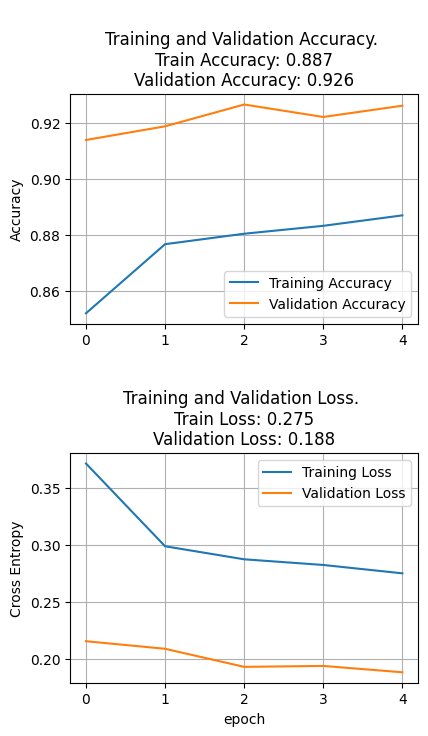

In [52]:
plot_history(inceptionv3_history)

#### MobileNetV2 Setup

##### Model Definition:

In [53]:
# load the pre-trained inception model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

In [54]:
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # 2 classes: adult and child

In [55]:
# Create the final model
mobilenetv2_model = Model(inputs=base_model.input, outputs=predictions)

In [56]:
mobilenetv2_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']      

##### Some tuning for learning rate:

In [57]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [58]:
mobilenetv2_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

##### Training model:

In [59]:
# Train the model
mobilenetv2_history = mobilenetv2_model.fit(train_generator,
                       epochs=5,
                       validation_data=validation_generator,
                       callbacks=lr_schedule,
                       verbose=1)

Epoch 1/5


2023-07-06 21:27:39.610117: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-06 21:27:39.651943: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


1470/1470 [==============================] - ETA: 0s - loss: 0.4138 - accuracy: 0.8305

2023-07-06 21:29:46.006919: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-06 21:29:46.046902: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


1470/1470 [==============================] - 146s 97ms/step - loss: 0.4138 - accuracy: 0.8305 - val_loss: 0.2584 - val_accuracy: 0.8966 - lr: 1.0000e-04
Epoch 2/5
1470/1470 [==============================] - 177s 121ms/step - loss: 0.3159 - accuracy: 0.8687 - val_loss: 0.2512 - val_accuracy: 0.8989 - lr: 1.1220e-04
Epoch 3/5
1470/1470 [==============================] - 214s 146ms/step - loss: 0.2961 - accuracy: 0.8784 - val_loss: 0.2423 - val_accuracy: 0.9058 - lr: 1.2589e-04
Epoch 4/5
1470/1470 [==============================] - 196s 133ms/step - loss: 0.2869 - accuracy: 0.8818 - val_loss: 0.2409 - val_accuracy: 0.9033 - lr: 1.4125e-04
Epoch 5/5
1470/1470 [==============================] - 197s 134ms/step - loss: 0.2849 - accuracy: 0.8829 - val_loss: 0.2223 - val_accuracy: 0.9129 - lr: 1.5849e-04


##### Performance:

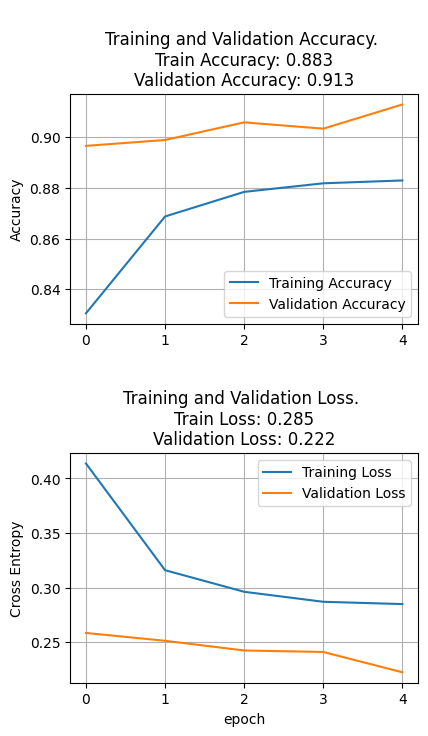

In [103]:
plot_history(mobilenetv2_history)

####  Final Comparision:

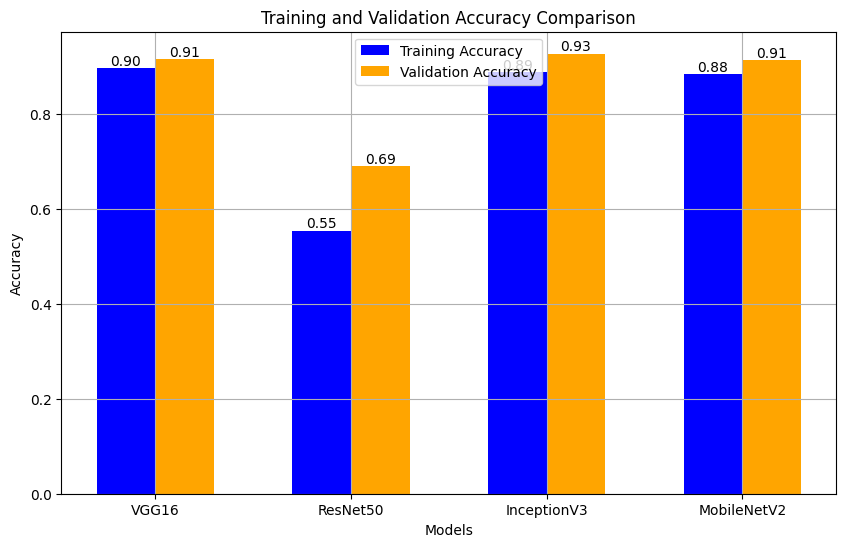

In [102]:
# Extract the training and validation accuracy values from the history object
plt.figure(figsize=(10, 6))
vgg16_train_acc = history.history['accuracy']
vgg16_val_acc = history.history['val_accuracy']
resnet50_train_acc = resnet50_history.history['accuracy']
resnet50_val_acc = resnet50_history.history['val_accuracy']
inceptionv3_train_acc = inceptionv3_history.history['accuracy']
inceptionv3_val_acc = inceptionv3_history.history['val_accuracy']
mobilenetv2_train_acc = mobilenetv2_history.history['accuracy']
mobilenetv2_val_acc = mobilenetv2_history.history['val_accuracy']

# Model names
models = ['VGG16', 'ResNet50', 'InceptionV3', 'MobileNetV2']

# Training and validation accuracy values
training_acc = [vgg16_train_acc[-1], resnet50_train_acc[-1], inceptionv3_train_acc[-1], mobilenetv2_train_acc[-1]]
validation_acc = [vgg16_val_acc[-1], resnet50_val_acc[-1], inceptionv3_val_acc[-1], mobilenetv2_val_acc[-1]]

# Set the width of the bars
bar_width = 0.3

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Create the bar plots
plt.bar(r1, training_acc, color='blue', width=bar_width, label='Training Accuracy')
plt.bar(r2, validation_acc, color='orange', width=bar_width, label='Validation Accuracy')

# Add values on top of each bar
for i in range(len(models)):
    plt.text(r1[i], training_acc[i], f'{training_acc[i]:.2f}', ha='center', va='bottom')
    plt.text(r2[i], validation_acc[i], f'{validation_acc[i]:.2f}', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)

# Add legend and show the plot
plt.legend()
plt.show()